# BAS SC10 – ASR-Evaluierung: Whisper Large V3 vs. Parakeet TDT v3

Dieses Notebook analysiert die Auswertungsergebnisse des BAS-SC10-Korpus. Der Fokus liegt auf den beiden integrierten ASR-Systemen und deren Word-Error-Rate (WER) je Aufnahmetyp und Sprecher:innensprache.

## Ziele
- Ergebnisse aus `bas_sc10.csv` laden und inspizieren
- WER-Statistiken der beiden Modelle gegenüberstellen
- Unterschiede über Aufnahmetypen (A–F) und Muttersprachen herausarbeiten
- Optional: Hochdeutsch-Übersetzungen mit Original-Transkriptionen vergleichen


In [12]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import paths

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20


In [13]:
output_root = Path(paths.OUTPUT_PATH or "").expanduser()
if not output_root.is_dir():
    raise FileNotFoundError("OUTPUT_PATH ist nicht gesetzt oder verweist auf kein existierendes Verzeichnis.")

csv_path = output_root / "bas_sc10.csv"
if not csv_path.is_file():
    raise FileNotFoundError(f"Erwartete Datei {csv_path} wurde nicht gefunden.")

df = pd.read_csv(csv_path)

wer_columns = [
    "whisper_large_v3_wer",
    "parakeet_tdt_v3_wer",
    "whisper_wer_hochdeutsch",
    "parakeet_wer_hochdeutsch",
]
for col in wer_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

has_parakeet = "parakeet_tdt_v3_wer" in df.columns
has_translation_cols = "hochdeutsch_translation" in df.columns

print(f"Anzahl Aufnahmen: {len(df):,}")
print(f"Sprecher:innen: {df['speaker_id'].nunique():,}")
print(f"Parakeet-Ergebnisse vorhanden: {has_parakeet}")
print(f"Hochdeutsch-Übersetzungen verfügbar: {has_translation_cols}")

display_cols = [
    "speaker_id",
    "recording_id",
    "recording_type_id",
    "speaker_language",
    "whisper_large_v3_wer",
]
if has_parakeet:
    display_cols.append("parakeet_tdt_v3_wer")
if has_translation_cols:
    display_cols.append("hochdeutsch_translation")
df[display_cols].head()


Anzahl Aufnahmen: 6,939
Sprecher:innen: 70
Parakeet-Ergebnisse vorhanden: True
Hochdeutsch-Übersetzungen verfügbar: True


,speaker_id,recording_id,recording_type_id,speaker_language,whisper_large_v3_wer,parakeet_tdt_v3_wer,hochdeutsch_translation
0,aem1,aem1a001,A,American,0.0,0.0,Heute ist schönes Frühlingswetter.
1,aem1,aem1a002,A,American,0.0,0.0,Die Sonne lächelt.
2,aem1,aem1a003,A,American,0.0,0.0,Im blauen Himmel ziehen die Wolken.
3,aem1,aem1a004,A,American,0.0,0.0,Über die Felder weht ein Wind.
4,aem1,aem1a005,A,American,0.0,0.0,Gestern war es noch stürmisch.


In [14]:
RECORDING_TYPE_LABELS = {
    "A": "A – Phonetisch balancierte Sätze (Deutsch)",
    "B": "B – Zahlenfolgen 1–100 (Deutsch)",
    "C": "C – Geschichte: Der Nordwind und die Sonne (Deutsch)",
    "D": "D – Geschichte: Der Nordwind und die Sonne (L1)",
    "E": "E – Dialog mit deutschsprachiger Person",
    "F": "F – Freies Nacherzählen (Deutsch)",
}

df["recording_type_label"] = df["recording_type_id"].map(RECORDING_TYPE_LABELS).fillna("Unbekannt")
df["speaker_language_clean"] = (
    df["speaker_language"].fillna("Unbekannt").astype(str).str.strip().replace({"": "Unbekannt"})
)

df["speaker_language_id"] = df["speaker_language_id"].astype(str).str.lower()
GERMAN_LANGUAGE_IDS = {"de"}
df["is_german_native"] = df["speaker_language_id"].isin(GERMAN_LANGUAGE_IDS)

if has_parakeet:
    df["wer_diff_models"] = df["parakeet_tdt_v3_wer"] - df["whisper_large_v3_wer"]

if has_translation_cols and {col for col in wer_columns if col in df.columns}:
    df["translation_available"] = df["hochdeutsch_translation"].fillna("").str.strip() != ""
else:
    df["translation_available"] = False

print("Verteilung Aufnahmetypen:")
print(df["recording_type_label"].value_counts())
print("\nTop 10 Sprecher:innensprachen:")
print(df["speaker_language_clean"].value_counts().head(10))


Verteilung Aufnahmetypen:
recording_type_label
B – Zahlenfolgen 1–100 (Deutsch)                        2100
A – Phonetisch balancierte Sätze (Deutsch)              2099
E – Dialog mit deutschsprachiger Person                 1303
F – Freies Nacherzählen (Deutsch)                       1168
C – Geschichte: Der Nordwind und die Sonne (Deutsch)     147
D – Geschichte: Der Nordwind und die Sonne (L1)          122
Name: count, dtype: int64

Top 10 Sprecher:innensprachen:
speaker_language_clean
Russian      994
Italian      637
Spanish      495
German       489
Polish       471
Hungarian    436
Svedish      422
French       405
American     364
Japanese     335
Name: count, dtype: int64


In [15]:
if has_parakeet:
    comparison_stats = pd.DataFrame({
        "Whisper Large V3": df["whisper_large_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]),
        "Parakeet TDT v3": df["parakeet_tdt_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]),
    })

    missing_whisper = df["whisper_large_v3_wer"].isna().sum()
    missing_parakeet = df["parakeet_tdt_v3_wer"].isna().sum()
    print(f"Fehlende WER-Werte → Whisper: {missing_whisper}, Parakeet: {missing_parakeet}")

    comparison_stats
else:
    missing = df["whisper_large_v3_wer"].isna().sum()
    print(f"Fehlende WER-Werte: {missing}")
    df["whisper_large_v3_wer"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])


Fehlende WER-Werte → Whisper: 259, Parakeet: 263


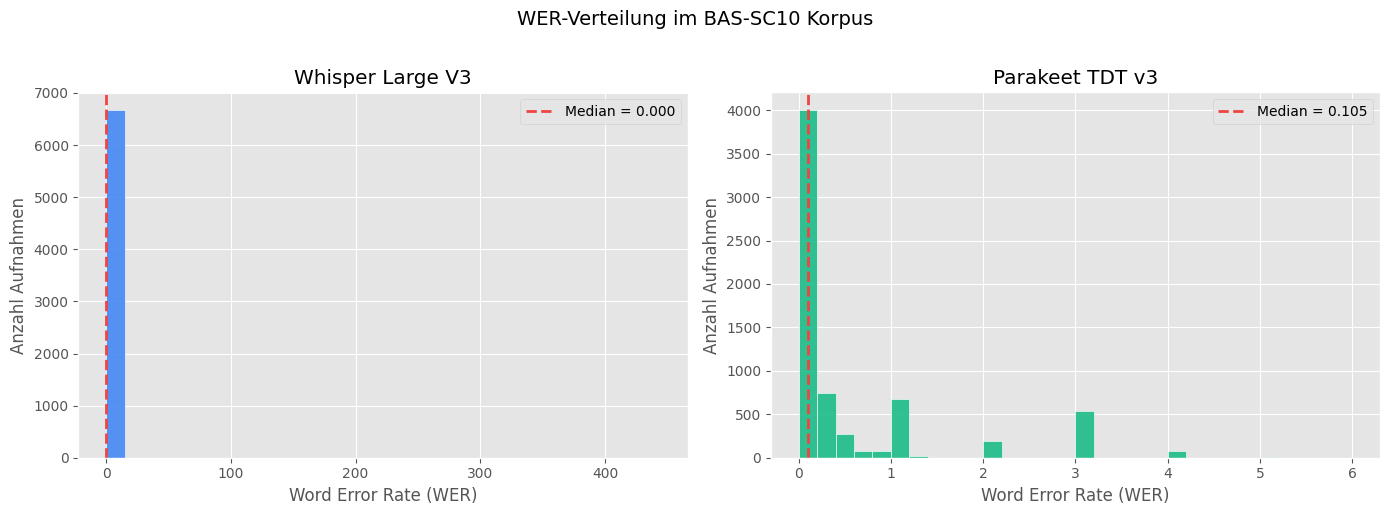

In [16]:
if has_parakeet:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    whisper_wer = df["whisper_large_v3_wer"].dropna()
    axes[0].hist(whisper_wer, bins=30, color="#3B82F6", edgecolor="white", alpha=0.85)
    axes[0].axvline(whisper_wer.median(), color="#EF4444", linestyle="--", linewidth=2, label=f"Median = {whisper_wer.median():.3f}")
    axes[0].set_xlabel("Word Error Rate (WER)")
    axes[0].set_ylabel("Anzahl Aufnahmen")
    axes[0].set_title("Whisper Large V3")
    axes[0].legend()

    parakeet_wer = df["parakeet_tdt_v3_wer"].dropna()
    axes[1].hist(parakeet_wer, bins=30, color="#10B981", edgecolor="white", alpha=0.85)
    axes[1].axvline(parakeet_wer.median(), color="#EF4444", linestyle="--", linewidth=2, label=f"Median = {parakeet_wer.median():.3f}")
    axes[1].set_xlabel("Word Error Rate (WER)")
    axes[1].set_ylabel("Anzahl Aufnahmen")
    axes[1].set_title("Parakeet TDT v3")
    axes[1].legend()

    fig.suptitle("WER-Verteilung im BAS-SC10 Korpus", fontsize=14, y=1.02)
    plt.tight_layout()
else:
    fig, ax = plt.subplots(figsize=(10, 4))
    wer_values = df["whisper_large_v3_wer"].dropna()
    ax.hist(wer_values, bins=30, color="#3B82F6", edgecolor="white")
    ax.axvline(wer_values.median(), color="#EF4444", linestyle="--", linewidth=2, label=f"Median = {wer_values.median():.3f}")
    ax.set_xlabel("Word Error Rate (WER)")
    ax.set_ylabel("Anzahl Aufnahmen")
    ax.set_title("WER-Verteilung Whisper Large V3")
    ax.legend()
    plt.tight_layout()


In [23]:
print(  df.sort_values("whisper_large_v3_wer", ascending=False).head(10)[[
      "speaker_id", "recording_id", "gt_transcription",
      "whisper_large_v3_transcription", "whisper_large_v3_wer"
  ]]
        )

     speaker_id recording_id  \
1000       dem1     dem1b033   
5572       spm1     spm1f010   
3568       nlw2     nlw2e008   
1589       fiw1     fiw1e020   
781        bew1     bew1b069   
3778       pgm1     pgm1b088   
5470       spm1     spm1b037   
3717       pgm1     pgm1b027   
5495       spm1     spm1b062   
5494       spm1     spm1b061   

                                       gt_transcription  \
1000                                    dreiunddreissig   
5572         und deswegen die Frau war ganz unzufrieden   
3568  nein nein nein nein aber ich habe mal bei für ...   
1589  viel viel weniger als hier in Deutschland ich ...   
781                                      neunundsechzig   
3778                                     achtundachtzig   
5470                                  siebenunddreissig   
3717                                   siebenundzwanzig   
5495                                     zweiundsechzig   
5494                                      einundsechzig  

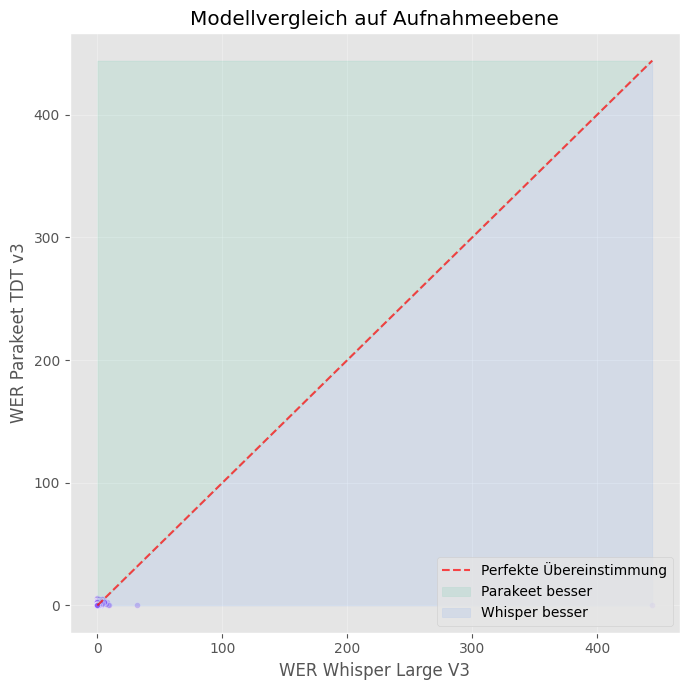

In [17]:
if has_parakeet:
    valid_pairs = df.dropna(subset=["whisper_large_v3_wer", "parakeet_tdt_v3_wer"])
    if not valid_pairs.empty:
        fig, ax = plt.subplots(figsize=(7, 7))

        ax.scatter(
            valid_pairs["whisper_large_v3_wer"],
            valid_pairs["parakeet_tdt_v3_wer"],
            s=18,
            alpha=0.35,
            color="#8B5CF6",
            edgecolors="white",
            linewidth=0.4,
        )

        max_wer = max(valid_pairs["whisper_large_v3_wer"].max(), valid_pairs["parakeet_tdt_v3_wer"].max())
        ax.plot([0, max_wer], [0, max_wer], "r--", linewidth=1.5, alpha=0.7, label="Perfekte Übereinstimmung")

        ax.fill_between([0, max_wer], [0, max_wer], max_wer, color="#10B981", alpha=0.1, label="Parakeet besser")
        ax.fill_between([0, max_wer], 0, [0, max_wer], color="#3B82F6", alpha=0.1, label="Whisper besser")

        ax.set_xlabel("WER Whisper Large V3")
        ax.set_ylabel("WER Parakeet TDT v3")
        ax.set_title("Modellvergleich auf Aufnahmeebene")
        ax.grid(alpha=0.3)
        ax.legend(loc="lower right")
        plt.tight_layout()
    else:
        print("Keine gemeinsamen WER-Werte für beide Modelle verfügbar.")
else:
    print("Parakeet-Ergebnisse fehlen – Scatter-Plot nicht möglich.")


## Aufnahmetyp-Analyse


In [18]:
min_type_samples = 50

if has_parakeet:
    type_metrics = (
        df.dropna(subset=["whisper_large_v3_wer", "parakeet_tdt_v3_wer"])
          .groupby("recording_type_label")
          .agg(
              samples=("whisper_large_v3_wer", "count"),
              whisper_mean=("whisper_large_v3_wer", "mean"),
              whisper_median=("whisper_large_v3_wer", "median"),
              parakeet_mean=("parakeet_tdt_v3_wer", "mean"),
              parakeet_median=("parakeet_tdt_v3_wer", "median"),
          )
    )

    type_metrics["wer_diff"] = type_metrics["parakeet_mean"] - type_metrics["whisper_mean"]
    type_metrics = (
        type_metrics.loc[type_metrics["samples"] >= min_type_samples]
        .sort_values("parakeet_mean")
        .round({"whisper_mean": 3, "whisper_median": 3, "parakeet_mean": 3, "parakeet_median": 3, "wer_diff": 3})
    )

    print(f"Aufnahmetypen mit mindestens {min_type_samples} Aufnahmen: {len(type_metrics)}")
    type_metrics
else:
    type_metrics = (
        df.dropna(subset=["whisper_large_v3_wer"])
          .groupby("recording_type_label")
          .agg(
              samples=("whisper_large_v3_wer", "count"),
              whisper_mean=("whisper_large_v3_wer", "mean"),
              whisper_median=("whisper_large_v3_wer", "median"),
          )
    )

    type_metrics = (
        type_metrics.loc[type_metrics["samples"] >= min_type_samples]
        .sort_values("whisper_mean")
        .round({"whisper_mean": 3, "whisper_median": 3})
    )

    print(f"Aufnahmetypen mit mindestens {min_type_samples} Aufnahmen: {len(type_metrics)}")
    type_metrics


Aufnahmetypen mit mindestens 50 Aufnahmen: 5


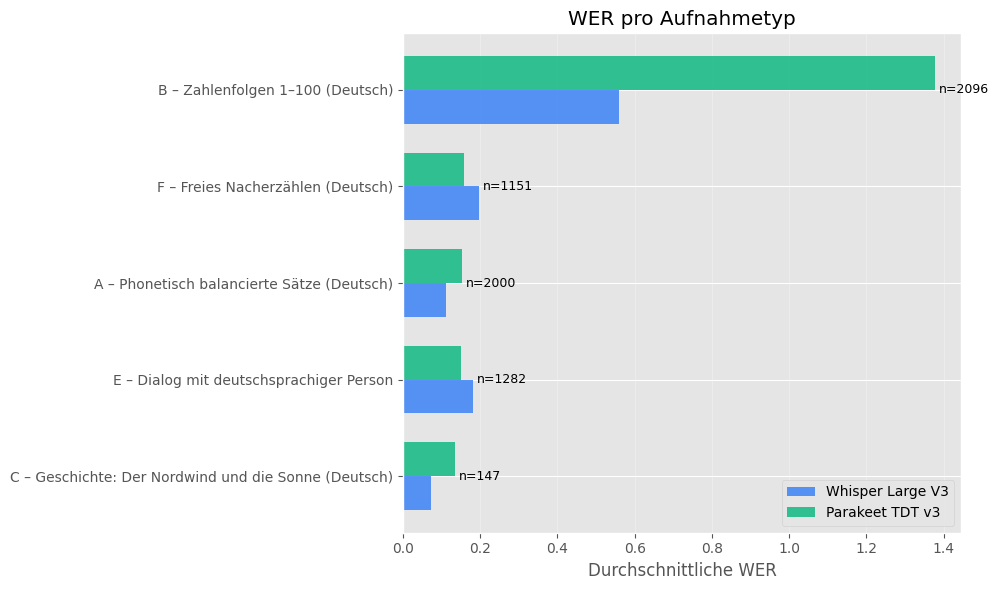

In [19]:
if has_parakeet and not type_metrics.empty:
    fig, ax = plt.subplots(figsize=(10, 6))

    types = type_metrics.index.tolist()
    y_pos = list(range(len(types)))
    width = 0.35

    ax.barh(
        [y - width / 2 for y in y_pos],
        type_metrics["whisper_mean"],
        height=width,
        color="#3B82F6",
        alpha=0.85,
        label="Whisper Large V3",
    )
    ax.barh(
        [y + width / 2 for y in y_pos],
        type_metrics["parakeet_mean"],
        height=width,
        color="#10B981",
        alpha=0.85,
        label="Parakeet TDT v3",
    )

    for y, samples in zip(y_pos, type_metrics["samples"]):
        ax.text(
            max(type_metrics.iloc[y][["whisper_mean", "parakeet_mean"]]) + 0.01,
            y,
            f"n={int(samples)}",
            va="center",
            fontsize=9,
        )

    ax.set_yticks(y_pos)
    ax.set_yticklabels(types)
    ax.set_xlabel("Durchschnittliche WER")
    ax.set_title("WER pro Aufnahmetyp")
    ax.legend(loc="lower right")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
elif not type_metrics.empty:
    fig, ax = plt.subplots(figsize=(10, 5))
    type_metrics["whisper_mean"].plot.barh(color="#3B82F6", ax=ax)
    ax.set_xlabel("Durchschnittliche WER")
    ax.set_ylabel("Aufnahmetyp")
    ax.set_title("WER pro Aufnahmetyp – Whisper Large V3")
    for y, (label, row) in enumerate(type_metrics.iterrows()):
        ax.text(row["whisper_mean"], y, f" n={int(row['samples'])}", va="center")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
else:
    print("Keine Aufnahmetypen erfüllen das Mindestkriterium.")


## Analyse nach Sprecher:innensprache


In [20]:
min_language_samples = 100

language_metrics = (
    df.dropna(subset=["whisper_large_v3_wer"])
      .groupby("speaker_language_clean")
      .agg(
          samples=("whisper_large_v3_wer", "count"),
          whisper_mean=("whisper_large_v3_wer", "mean"),
      )
)

round_map = {"whisper_mean": 3}

if has_parakeet:
    parakeet_stats = (
        df.dropna(subset=["parakeet_tdt_v3_wer"])
          .groupby("speaker_language_clean")["parakeet_tdt_v3_wer"].agg(["mean", "median"])
          .rename(columns={"mean": "parakeet_mean", "median": "parakeet_median"})
    )
    language_metrics = language_metrics.join(parakeet_stats, how="left")
    language_metrics["wer_diff"] = language_metrics["parakeet_mean"] - language_metrics["whisper_mean"]
    round_map.update({"parakeet_mean": 3, "parakeet_median": 3, "wer_diff": 3})

language_metrics = (
    language_metrics.loc[language_metrics["samples"] >= min_language_samples]
      .sort_values("whisper_mean")
      .round(round_map)
)

print(f"Sprachen mit mindestens {min_language_samples} Aufnahmen: {len(language_metrics)}")
language_metrics


Sprachen mit mindestens 100 Aufnahmen: 17


,samples,whisper_mean,parakeet_mean,parakeet_median,wer_diff
speaker_language_clean,,,,,
Turkish,244,0.049,0.566,0.000,0.517
Polish,463,0.085,0.310,0.056,0.225
Svedish,416,0.108,0.560,0.125,0.452
Russian,877,0.112,0.419,0.044,0.307
Italian,625,0.121,0.419,0.049,0.298
Dutch,275,0.125,0.673,0.000,0.548
American,321,0.125,0.501,0.091,0.376
Finnish,324,0.128,0.616,0.125,0.488
Hungarian,427,0.137,0.320,0.077,0.183


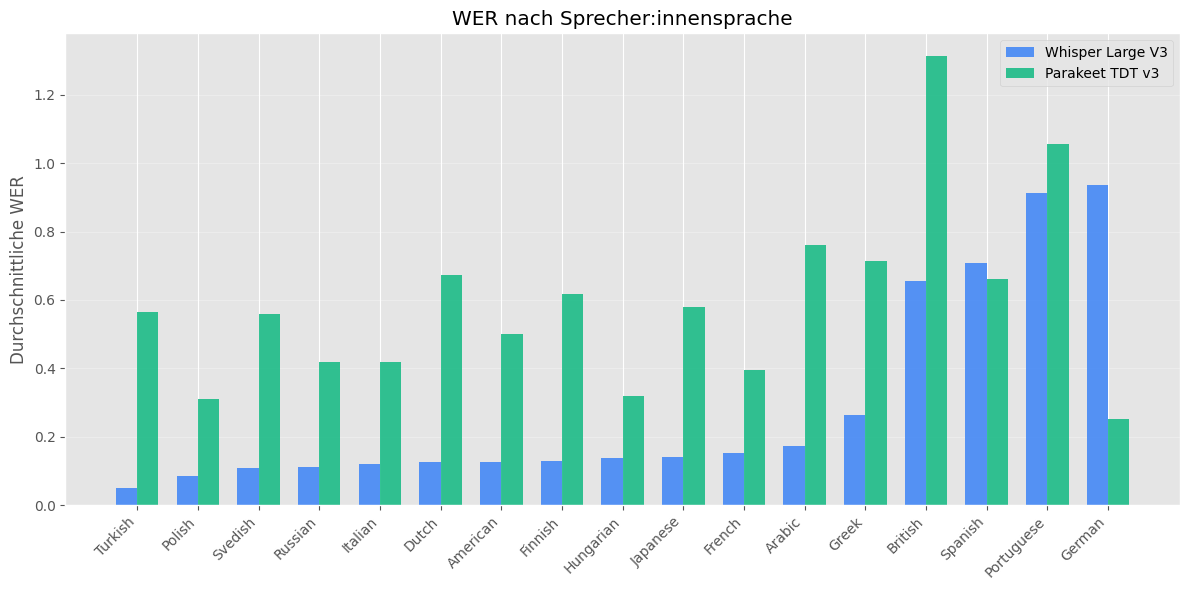

In [21]:
if not language_metrics.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    languages = language_metrics.index.tolist()
    x_pos = list(range(len(languages)))
    width = 0.35

    if has_parakeet and "parakeet_mean" in language_metrics:
        ax.bar(
            [x - width / 2 for x in x_pos],
            language_metrics["whisper_mean"],
            width=width,
            color="#3B82F6",
            alpha=0.85,
            label="Whisper Large V3",
        )
        ax.bar(
            [x + width / 2 for x in x_pos],
            language_metrics["parakeet_mean"],
            width=width,
            color="#10B981",
            alpha=0.85,
            label="Parakeet TDT v3",
        )
    else:
        ax.bar(x_pos, language_metrics["whisper_mean"], width=width, color="#3B82F6", alpha=0.85)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(languages, rotation=45, ha="right")
    ax.set_ylabel("Durchschnittliche WER")
    ax.set_title("WER nach Sprecher:innensprache")
    if has_parakeet and "parakeet_mean" in language_metrics:
        ax.legend(loc="upper right")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
else:
    print("Keine Sprachen erfüllen das Mindestkriterium.")


## Vergleich Ground-Truth vs. Hochdeutsch-Übersetzung


In [22]:
if has_translation_cols:
    translation_df = df[df["translation_available"]].copy()
    if translation_df.empty:
        print("Keine Hochdeutsch-Übersetzungen im Datensatz.")
    else:
        summary = {}
        summary["Anzahl Segmente"] = len(translation_df)

        summary["Whisper – Original WER"] = translation_df["whisper_large_v3_wer"].mean()
        summary["Whisper – Hochdeutsch WER"] = translation_df["whisper_wer_hochdeutsch"].mean()

        if has_parakeet:
            summary["Parakeet – Original WER"] = translation_df["parakeet_tdt_v3_wer"].mean()
            summary["Parakeet – Hochdeutsch WER"] = translation_df["parakeet_wer_hochdeutsch"].mean()

        for key in list(summary.keys()):
            if key.startswith("Whisper") or key.startswith("Parakeet"):
                summary[key] = round(summary[key], 3)

        for label, value in summary.items():
            print(f"{label}: {value}")
else:
    print("Keine Hochdeutsch-Übersetzungen verfügbar.")


Anzahl Segmente: 6678
Whisper – Original WER: 0.279
Whisper – Hochdeutsch WER: 0.471
Parakeet – Original WER: 0.537
Parakeet – Hochdeutsch WER: 0.705
